In [325]:
import torch
from PetDataset import PetDataset
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
PSIZE=256

cuda:0


In [326]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((PSIZE, PSIZE)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = PetDataset(data_transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)

dataiter = iter(dataloader)

images, labels = dataiter.next()

labels


tensor([0.6300, 0.4200, 0.2800, 0.1500], dtype=torch.float64)

In [327]:
def out_size(h,k, p=0,dd=1,s=1):
    return int((h+2*p-dd*(k-1)-1)/s + 1)
a=out_size(64, 5)
print(a)
b=out_size(a, 2, 0, 1, 2)
print(b)
c=out_size(b, 5)
print(c)
d=out_size(c,2,0,1,2)
print(d)

60
30
26
13


In [328]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.a = out_size(PSIZE, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.b = out_size(self.a, 2, 0, 1, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)
        self.c = out_size(self.b, 5)
        self.d = out_size(self.c, 2, 0, 1, 2)

        # self.conv3 = nn.Conv2d(16, 5, 5)
        # self.e = out_size(self.d, 5)
        # self.f = out_size(self.e, 2, 0, 1, 2)

        self.fc1 = nn.Linear(16 * self.d * self.d, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * self.d * self.d)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        # x = (100*x.view(-1)).int()/100
        # x.requires_grad=True
        return x.view(-1)

In [329]:
import torch.optim as optim
net = Net()
net.to(device)
criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')


[1,   200] loss: 0.046
[1,   400] loss: 0.050
[1,   600] loss: 0.046
[1,   800] loss: 0.046
[1,  1000] loss: 0.039
[1,  1200] loss: 0.043
[1,  1400] loss: 0.048
[1,  1600] loss: 0.040
[1,  1800] loss: 0.046
[1,  2000] loss: 0.038
[1,  2200] loss: 0.042
[1,  2400] loss: 0.043
[2,   200] loss: 0.041
[2,   400] loss: 0.047
[2,   600] loss: 0.045
[2,   800] loss: 0.045
[2,  1000] loss: 0.037
[2,  1200] loss: 0.041
[2,  1400] loss: 0.047
[2,  1600] loss: 0.040
[2,  1800] loss: 0.045
[2,  2000] loss: 0.038
[2,  2200] loss: 0.042
[2,  2400] loss: 0.042
[3,   200] loss: 0.040
[3,   400] loss: 0.047
[3,   600] loss: 0.044
[3,   800] loss: 0.045
[3,  1000] loss: 0.037
[3,  1200] loss: 0.038
[3,  1400] loss: 0.044
[3,  1600] loss: 0.036
[3,  1800] loss: 0.040
[3,  2000] loss: 0.032
[3,  2200] loss: 0.040
[3,  2400] loss: 0.039
[4,   200] loss: 0.037
[4,   400] loss: 0.042
[4,   600] loss: 0.037
[4,   800] loss: 0.037
[4,  1000] loss: 0.033
[4,  1200] loss: 0.032
[4,  1400] loss: 0.033
[4,  1600] 

In [330]:
correct = 0
total = 0
iter_i = 0

with torch.no_grad():
    for data in dataloader:
        inputs, _ = data[0].to(device), data[1].to(device)
        outputs = net(inputs)

        if iter_i == 0:
            d = outputs
        else:
            d = torch.cat((d, outputs), 0)

        iter_i += 1

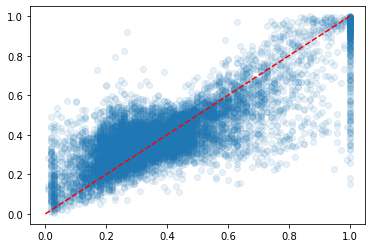

In [331]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("petfinder-pawpularity-score/train.csv")
plt.scatter(df["Pawpularity"]/100, d.cpu().numpy(), alpha=0.1)
plt.plot([0,1],[0,1],c='red',ls='--')